# Regional sea ice concentration and thickness for CMIP6 large ensembles

### Author - Chris Wyburn-Powell, see the latest version on [github](https://github.com/chrisrwp/low-frequency-variability/blob/main/input_data/Regional_sea_ice_CMIP6.ipynb)


**Input:**
- Sea ice concentration (SIC) from variable `siconc` or `siconca` and sea ice thickness (SIT) from variable `sithick` (note `sivol` is unavailible for some models).  Historical forcings are used for 1850-2014 for the following CMIP6 models which provide large ensembles with member numbers in parentheses:
    - CanESM5 (65 for siconc, 40 for sithick)
    - MIROC6 (50)
    - GISS-E2-1-G (43)
    - IPSL-CM6A-LR (32)
    - CNRM-CM6-1 (30)
    - NorCPM1 (21 - 9 more awaited)
- Regridded MASIE regions for each model

**Output:**
- SIA for each region, 1850-2014
- Average SIC for each region, 1850-2014
- SIV for each region, 1850-2014
- Average SIT for each region, 1850-2014
- Pan-Arctic SIA, 1850-2014
- Pan-Arctic SIV, 1850-2014
- Linear detrended and 2 year lowpass filter of regional SIC and SIT, 1920-2014

In [1]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal
import datetime
import os
import pickle
import glob
import re
import dask
print(datetime.datetime.now())

2022-09-18 17:40:59.480516


In [33]:
#the following dask workers are sufficient for processing around 100 members
from dask_jobqueue import PBSCluster
from dask.distributed import Client

cluster = PBSCluster(cores    = 1,
                     memory   = '11GB',
                     queue    = 'casper',
                     walltime = '00:05:00',
                     project='UCUB0084')

cluster.scale(16)
client = Client(cluster)
client

/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33250 instead
  http_address["port"], self.http_server.port


Client Scheduler: tcp://10.12.206.63:41197 Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/cwpowell/proxy/33250/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


## Load useful information

In [2]:
CMIP6_info = xr.open_dataset(
    '/glade/work/cwpowell/low-frequency-variability/raw_data/CMIP6_info/'\
    +'CMIP6_modeling_center_members_doi.nc'
)

xr_new_time = xr.open_dataarray(
    '/glade/work/cwpowell/low-frequency-variability/raw_data/'\
    +'datetime64_1850_2100_monthly.nc')

In [3]:
with open('/glade/work/cwpowell/low-frequency-variability/raw_data/CMIP6_info/'\
          +'CMIP6_SImon_siconc_paths.pickle', 'rb') as handle:
    siconc_paths = pickle.load(handle)
    
with open('/glade/work/cwpowell/low-frequency-variability/raw_data/CMIP6_info/'\
          +'CMIP6_SImon_sivol_sithick_paths.pickle', 'rb') as handle:
    sivol_sithick_paths = pickle.load(handle)

with open('/glade/work/cwpowell/low-frequency-variability/raw_data/CMIP6_info/'\
          +'CMIP6_SImon_var_availibility.pickle', 'rb') as handle:
    var_availibility = pickle.load(handle)

with open('/glade/work/cwpowell/low-frequency-variability/raw_data/CMIP6_info/'\
          +'CMIP6_areacello_paths.pickle', 'rb') as handle:
    areacello_paths = pickle.load(handle)
    
with open('/glade/work/cwpowell/low-frequency-variability/raw_data/CMIP6_info/'\
          +'CMIP6_areacello_lat_names.pickle', 'rb') as handle:
    lat_names = pickle.load(handle)
    
with open('/glade/work/cwpowell/low-frequency-variability/raw_data/CMIP6_info/'\
          +'CMIP6_x_y_names.pickle', 'rb') as handle:
    x_y_names = pickle.load(handle)

## Define function for loading data

In [4]:
def load_member_CMIP6(model, ripf, output_var, chunk=False):
    '''
    Open a single member file of either sea ice concentration or thickness
    from glade using xarray.open_dataset
    
    Parameters
    ----------
    model: string
        The name of the model e.g. CanESM5
    ripf : string,
        r<>: realisation (i.e. ensemble member), i<>: initialisation method, 
        p<>: physics, f<>: forcing, e.g. r15i1p2f1
    output_var : string,
        Variable of concentration of volume e.g. 'siconc', 'sivol', 'sithick',
        N.B. either sivol or sithick will chose whichever of the 2 has the best
        availibility as previously found when defining sicol_sithick_paths
    chunk : bool, optional
        Open with dask chunks (auto chunked) if true, do not use dask is false
    
    Returns
    ----------
        xarray.DataSet object from glade sea ice output
    '''  
    
    if output_var in ['siconc']:
        paths = siconc_paths[model+'_'+ripf]
    elif output_var in ['sithick', 'sivol']:
        paths = sivol_sithick_paths[model+'_'+ripf]
    else:
        print('variable not availible')
        
    ########## use the file path to open the NetCDF file using xarray ##########    
    if type(paths) == list:
    
        if chunk:
            if len(paths) > 1:
                if model[0:2] == 'EC':
                    data = xr.open_mfdataset(paths, combine='nested', 
                                             concat_dim='time', 
                                             chunks='auto')
                else:
                    data = xr.open_mfdataset(paths, combine='nested', 
                                             concat_dim='time', 
                                             chunks={'time':198})
            elif len(paths) == 1:
                data = xr.open_mfdataset(paths[0], combine='nested', 
                                         concat_dim='time', chunks={'time':198})
            else:
                data = xr.open_dataset(paths, chunks={'time':198})
        
        else:
            if len(paths) > 1:
                data = xr.open_mfdataset(paths, combine='nested', 
                                         concat_dim='time')
            else:
                data = xr.open_dataset(paths[0])
            
    else: 
        print('no data availible for', model, ripf, output_var)
        data = np.nan
            
    return(data)

In [6]:
def load_member_CMIP6(model, ripf, output_var, chunk=False):
    '''
    Open a single member file of either sea ice concentration or thickness
    from glade using xarray.open_dataset
    
    Parameters
    ----------
    model: string
        The name of the model e.g. CanESM5
    ripf : string,
        r<>: realisation (i.e. ensemble member), i<>: initialisation method, 
        p<>: physics, f<>: forcing, e.g. r15i1p2f1
    output_var : string,
        Variable of concentration of volume e.g. 'siconc', 'sivol', 'sithick'
    chunk : bool, optional
        Open with dask chunks (auto chunked) if true, do not use dask is false
    
    Returns
    ----------
        xarray.DataSet object from glade sea ice output
    '''  
    
    multi_file = False #assume a single file unless otherwise for certain models
    
    base_path = '/glade/collections/cmip/CMIP6/CMIP/'\
        +'{}/{}/historical/{}/'.format(model_centers[model], model, ripf)\
        +'SImon/{}/'.format(output_var)
    
    ############### generate the file path ###############
    
    ##### CanESM5 #####
    if model == 'CanESM5':
        path = base_path+'gn/v20190429/{}/{}'.format(output_var, output_var)\
            +'_SImon_CanESM5_historical_{}_gn_185001-201412.nc'.format(ripf)
    
    
    
    ##### EC-Earth3 #####
    elif model == 'MIROC6':
        if ripf[2] == 'i' or ripf[1:3] == '10': 
            i = '20181212'
        else:
            i = '20200519'
                
        multi_file = True
        
        path = [
            base_path+'gn/v{}/{}/{}'.format(i, output_var, output_var)\
            +'_SImon_MIROC6_historical_{}_gn_185001-194912.nc'.format(ripf),
            base_path+'gn/v{}/{}/{}'.format(i, output_var, output_var)\
            +'_SImon_MIROC6_historical_{}_gn_195001-201412.nc'.format(ripf),
        ]
    
    ##### MIROC6 #####
    elif model == 'MIROC6':
        if ripf[2] == 'i' or ripf[1:3] == '10': 
            i = '20181212'
        else:
            i = '20200519'
                
        multi_file = True
        
        path = [
            base_path+'gn/v{}/{}/{}'.format(i, output_var, output_var)\
            +'_SImon_MIROC6_historical_{}_gn_185001-194912.nc'.format(ripf),
            base_path+'gn/v{}/{}/{}'.format(i, output_var, output_var)\
            +'_SImon_MIROC6_historical_{}_gn_195001-201412.nc'.format(ripf),
        ]
        
    ##### GISS-E2-1-G #####
    elif model == 'GISS-E2-1-G':
        if ripf[-4:] == 'p3f1': 
            i = '20190702'
        elif ripf[1:4] in ['101', '102']:
            i = '20190815'
        elif ripf[-4:] == 'p1f1' and ripf[0:3] in ['r1i', 'r2i']:
            i = '20180827'
        elif ripf[-4:] == 'p1f1' and ripf[1] in ['3', '4', '5']:
            i = '20180828'
        elif ripf[-4:] == 'p1f1' and ripf[1] in ['6', '7']:
            i = '20180829'      
        elif ripf[-4:] == 'p1f1' and ripf[0:3] in ['r8i', 'r9i', 'r10']:
            i = '20180830'      
        elif ripf[-4:] in ['p1f2', 'p1f3']:
            i = '20190903'  
        elif ripf[-4:] == 'p5f1':
            i = '20190905'    
        else: 
            print('invalid variant ID')
        
        multi_file = True

        path = [
            base_path+'gn/v{}/{}/{}_'.format(i, output_var, output_var)\
            +'SImon_GISS-E2-1-G_historical_{}_gn_'.format(ripf)\
            +'185001-190012.nc',
            base_path+'gn/v{}/{}/{}_'.format(i, output_var, output_var)\
            +'SImon_GISS-E2-1-G_historical_{}_gn_'.format(ripf)\
            +'190101-195012.nc',
            base_path+'gn/v{}/{}/{}_'.format(i, output_var, output_var)\
            +'SImon_GISS-E2-1-G_historical_{}_gn_'.format(ripf)\
            +'195101-200012.nc',
            base_path+'gn/v{}/{}/{}_'.format(i, output_var, output_var)\
            +'SImon_GISS-E2-1-G_historical_{}_gn_'.format(ripf)\
            +'200101-201412.nc',
        ]

    ##### IPSL-CM6A-LR #####
    elif model == 'IPSL-CM6A-LR':
        if ripf[:4] == 'r32i':
            i = '90802'
        else:
            i = '80803'

        path = base_path+'gn/v201{}/{}/{}_'.format(i, output_var, output_var)\
            +'SImon_IPSL-CM6A-LR_historical_{}_gn_185001-201412.nc'.format(ripf)
    
    ##### CNRM-CM6-1 #####
    elif model == 'CNRM-CM6-1':
        if ripf == 'r1i1p1f2':
            i = '20180917'
        elif ripf == 'r2i1p1f2':
            i = '20181126'
        elif int(ripf[1]) in np.arange(3,10) or ripf[1:3] == '10':
            i = '20190125'
        elif int(ripf[1:3]) in np.arange(11,21):
            i = '20191004'
        elif ripf in ['r29i1p1f1', 'r29i1p1f2']:
            i = '20200529'
        else:
            print('invalid variant ID')

        path = base_path+'gn/v{}/{}/{}_'.format(i, output_var, output_var)\
            +'SImon_CNRM-CM6-1_historical_{}_gn_185001-201412.nc'.format(ripf)
    
    ##### NorCPM1 #####
    elif model == 'NorCPM1':
        if ripf[1:3] in ['15', '16', '22', '23', '26', '28', '30'] and \
            output_var == 'sithick':
            i = '20190914'
        else:
            i = '20200724'
            
        path = base_path+'gn/v{}/{}/{}_'.format(i, output_var, output_var)\
            +'SImon_NorCPM1_historical_{}_gn_185001-201412.nc'.format(ripf)
        
    else:
        print('invalid model name')
       
    ########## use the file path to open the NetCDF file using xarray ##########
    if chunk:
        if multi_file:
            if model == 'GISS-E2-1-G':
                data = xr.open_mfdataset(path, combine='nested', 
                                         concat_dim='time', chunks={'time':198})
            else:
                data = xr.open_mfdataset(path, combine='nested', 
                                         concat_dim='time', chunks='auto')
        
        else: #note CanESM5 doesn't like auto selection of chunk sizes
            data = xr.open_dataset(path, chunks={'time':198})
    else:
        if multi_file:
            data = xr.open_mfdataset(path, combine='nested', concat_dim='time')
        else:
            data = xr.open_dataset(path)
            
    return(data)

## Make the region masks and define location of areacello files

In [119]:
#make reduced areacello files for all models to only include 30-90N
for model_name in CMIP6_info['model'].values:
    try:
        areacello = xr.open_dataset(areacello_paths[model_name])
        
        try:
            areacello_30N = areacello['areacello'].where(
                areacello[lat_names[model_name]]>30)
        
        except KeyError:
            areacello = areacello.rename({'areacella':'areacello'})
            areacello_30N = areacello['areacello'].where(
                areacello[lat_names[model_name]]>30)
            
        areacello_30N.attrs = areacello.attrs.copy()
        areacello_30N.to_netcdf(
            '/glade/work/cwpowell/low-frequency-variability/'\
            +'raw_data/masie_masks/areacello_{}_30N.nc'.format(model_name))
    
    except AttributeError:
        print(model_name, 'no areacello to extract northern hemisphere data')

In [32]:
# #make reduced areacello files for GISS-E2-1-G as uses areacella
# model_name = 'GISS-E2-1-G'
# areacella = xr.open_dataset(areacello_paths[model_name])
# areacello = areacella.rename({'areacella':'areacello'})

# areacello_30N = areacello['areacello'].where(
#     areacello['lat']>30)

# areacello_30N.attrs = areacella.attrs.copy()
# areacello_30N.to_netcdf(
#     '/glade/work/cwpowell/low-frequency-variability/'\
#     +'raw_data/masie_masks/areacello_{}_30N.nc'.format(model_name))

**Regrid the MASIE region mask for each of the model grids, using nearest neighbor for the areacello files** <br>
**Use `regrid_MAISE_regions_to_areacello.sh`, with a single model exampled below:** <br>
`cdo remapnn,<areacello_path> /glade/work/cwpowell/low-frequency-variability/raw_data/masie_masks/masiemask_ims4km.nc /glade/work/cwpowell/low-frequency-variability/raw_data/masie_masks/masiemask_<model_name>.nc`

## Calculate the regional sea ice concentration and thickness with `dask`

In [5]:
def regional_calc_dask(model_name, mem, areacello_with_nan, region_mask,
                       start_yr_=False, end_yr_=False):
    '''
    Calculate regional SIA, SIC, SIV, SIT from glade files of concentration
    (siconc) and thickness (sithick) or derived from volume (sivol)
    from historical CMIP6 model runs. Regions based on NSIDC MASIE regions.

    Parameters
    ----------
    model_name: string
        The name of the model e.g. CanESM5
    mem: string
        Variant ID e.g. 'r1ip1f1' where the letters correspond to:
        r<>: realisation (i.e. ensemble member),
        i<>: initialisation method, p<>: physics, f<>: forcing
    areacello_with_nan: xarray dataarray
        areacello or areacella with latitudes below 30N set to np.nan
    region_mask: xarray dataarray
        dataarray with the same coordinates and dimensions as the sea ice 
        variable data but with values corresponding to region or np.nan for 
        outside of the regions domain

    Returns
    ----------
        xarray.Dataset with variables of:
        regional SIA, regional average SIC, regional SIV, regional average SIT,
        pan-Arctic SIA, pan-Arctic SIV
    '''  
    ################## determine if subset of years will be used ###############
    if start_yr_:
        start_yr = start_yr_
    else:
        start_yr = 1850
        
    if end_yr_:
        end_yr = end_yr_
    else:
        end_yr = 2014
    
    ########################### load the data files ############################
    #load the SIC and SIT data and select above 30N
    if type(siconc_paths[model_name+'_'+mem]) != list:
        no_siconc = True
        print(f'no data availible for {model_name} {mem} siconc')
    
    else:
        no_siconc = False
        SIC = load_member_CMIP6(model_name, mem, 'siconc', chunk=True)
        print(SIC)
        #remove concentration values below 30N and convert to fraction from %
        siconc_name = 'siconc'
        #only exceptions where siconc not availib
        if model_name in ['GISS-E2-1-G','GISS-E2-1-G-CC']: 
            siconc_name = 'siconca'
        
        SIC = SIC[siconc_name].where(areacello_with_nan, drop=False)/100
  
    #load sivol or sithick if sivol is not availible, or pass if neither availib 
    no_sivol_sithick = False
    if var_availibility[model_name] == 'sivol':
        #need to load sivol and divide by the grid cell area first
        SIV = load_member_CMIP6(model_name, mem, 'sivol', chunk=True)
        print(SIV)
        if type(SIV) == float:
            no_sivol_sithick = True
        else:
            if model_name == 'GISS-E2-1-H':
                SIT = SIV['sivol'].where(areacella_GISS_E2_1_G, drop=False)
            else:
                SIT = SIV['sivol'].where(areacello_with_nan, drop=False)
    
    elif var_availibility[model_name] == 'sithick':
        #no need to do calculations before processing the data, just load files
        SIT = load_member_CMIP6(model_name, mem, 'sithick', chunk=True)
        print(SIT)
        if type(SIT) == float:
            no_sivol_sithick = True
        else:
            SIT = SIT['sithick'].where(areacello_with_nan, drop=False)
    
    else:
        no_sivol_sithick = True
    
    #replace time with datetime64 for consistency across models
    if no_siconc == False:
        SIC = SIC.sortby('time') #EC Earth models do not automatically sort
        SIC = SIC.sel(time=slice(str(start_yr), str(end_yr))) 
        SIC['time'] = xr_new_time.sel(time=slice(str(start_yr),str(end_yr)))
    
    if no_sivol_sithick == False:
        SIT = SIT.sortby('time')
        SIT = SIT.sel(time=slice(str(start_yr), str(end_yr))) 
        SIT['time'] = xr_new_time.sel(time=slice(str(start_yr),str(end_yr)))

    ################ compute SIA, SIV and average SIC and SIT ##################
    #make an empty dataarray with nans for missing data
    xr_new_time_nan = xr_new_time.sel(
        time=slice(str(start_yr), str(end_yr))).astype(int).where(
        xr_new_time.sel(time=slice(str(start_yr), str(end_yr))).astype(
            int)==0.01,0
        )*np.nan
    
    #only do the calculation where there is sea ice
    if no_siconc == False:
        SIC = SIC.where(SIC>0)
    
    if no_sivol_sithick == False:
        SIT = SIT.where(SIT>0)
    
    #calculate the pan-Arctic SIA and SIV
    if no_siconc == False:
        pan_Arctic_SIA = (SIC * areacello_with_nan).sum(
            x_y_names[model_name][0]).sum(x_y_names[model_name][1])
    else:
        pan_Arctic_SIA = xr_new_time_nan
        
    if no_sivol_sithick==False:
        if model_name == 'GISS-E2-1-H':
            pan_Arctic_SIV = (SIT * areacella_GISS_E2_1_G).sum(
                x_y_names[model_name][0]).sum(x_y_names[model_name][1])
        else:
            pan_Arctic_SIV = (SIT * areacello_with_nan).sum(
                x_y_names[model_name][0]).sum(x_y_names[model_name][1])
    else:
        pan_Arctic_SIV = xr_new_time_nan
    
    #calculate regional data
    SIA_regions = []
    SIC_regions_av = []
    SIV_regions = []
    SIT_regions_av = []

    for region_ in np.arange(1,17):
        area_region = areacello_with_nan.where(
                region_mask['regions']==region_).sum()
        
        if no_siconc == False:
            SIC_region = SIC.where((region_mask['regions']==region_))
            SIA_region = (SIC_region * areacello_with_nan).sum(
                x_y_names[model_name][0]).sum(x_y_names[model_name][1])

            SIA_regions.append(SIA_region)
            SIC_regions_av.append(SIA_region / area_region)
        else:
            SIA_regions.append(xr_new_time_nan)
            SIC_regions_av.append(xr_new_time_nan)
        
        if no_sivol_sithick == False:
            if model_name == 'GISS-E2-1-H':
                SIT_region = SIT.where(
                    (region_mask_GISS_E2_1_G['regions']==region_))

                SIV_region = (SIT_region * areacella_GISS_E2_1_G).sum(
                    x_y_names[model_name][0]).sum(x_y_names[model_name][1])
            else:
                SIT_region = SIT.where((region_mask['regions']==region_))

                SIV_region = (SIT_region * areacello_with_nan).sum(
                    x_y_names[model_name][0]).sum(x_y_names[model_name][1])

            SIV_regions.append(SIV_region)
            SIT_regions_av.append(SIV_region / area_region)
        
        else: #append nan values of the same shape as the SIC derived data
            SIV_regions.append(xr_new_time_nan)
            SIT_regions_av.append(xr_new_time_nan)
            
    
    ######################### concatenate all regions ##########################
    SIA_regions =  xr.concat((SIA_regions),dim='region')
    SIA_regions['region'] = np.arange(1,17)
    SIC_regions_av = xr.concat((SIC_regions_av),dim='region')
    SIC_regions_av['region'] = np.arange(1,17)

    SIV_regions = xr.concat((SIV_regions),dim='region')
    SIV_regions['region'] = np.arange(1,17)
    SIT_regions_av = xr.concat((SIT_regions_av),dim='region')
    SIT_regions_av['region'] = np.arange(1,17)
    
    final_dataset = xr.Dataset(
            {'regional_SIA':SIA_regions, 'regional_SIC':SIC_regions_av,
             'regional_SIV':SIV_regions, 'regional_SIT':SIT_regions_av,
             'Arctic_SIA':pan_Arctic_SIA, 'Arctic_SIV':pan_Arctic_SIV
            }
        )
    
    if model_name not in ['GFDL-ESM4', 'MCM-UA-1-0', 'CESM2', 'CESM2-FV2',
                          'CESM2-WACCM', 'CESM2-WACCM-FV2', 'CIESM', 
                          'GFDL-CM4', 'KIOST-ESM']:
        if np.logical_not(np.logical_and(no_siconc, no_sivol_sithick)):
            final_dataset = final_dataset.drop('type')
    
    return(final_dataset)

### Compute each member of all models using dask

In [16]:
#the following needs to be defined if running GISS-E2-1-H
#this is because GISS-E2-1-H uses areacello for siconc and areacella for sivol,
#the areacella is the same shape as for GISS-E2-1-G
region_mask_GISS_E2_1_G = xr.open_dataset(
    '/glade/work/cwpowell/low-frequency-variability/raw_data/'\
    +'masie_masks/masiemask_GISS-E2-1-G.nc')

areacella_GISS_E2_1_G = xr.open_dataset(
        '/glade/work/cwpowell/low-frequency-variability/'\
        +'raw_data/masie_masks/areacello_GISS-E2-1-G_30N.nc')

areacella_GISS_E2_1_G = areacella_GISS_E2_1_G['areacello']

In [37]:
model_name = 'E3SM-1-0'

mem_list = CMIP6_info['members'].sel(model=model_name).where(
        CMIP6_info['members'].sel(model=model_name)!='0.0', drop=True).values

print(mem_list)
mem_list = ['r5i1p1f1']

#load the region masks
region_mask = xr.open_dataset(
    '/glade/work/cwpowell/low-frequency-variability/raw_data/'\
    +'masie_masks/masiemask_{}.nc'.format(model_name)
)

#load the areacello file
areacello_ = xr.open_dataset(
    '/glade/work/cwpowell/low-frequency-variability/'\
    +'raw_data/masie_masks/areacello_{}_30N.nc'.format(model_name)
)

areacello_with_nan = areacello_['areacello']

# areacello_with_nan['lon'] = region_mask['i'].values
# areacello_with_nan['lat'] = region_mask['j'].values
# areacello_with_nan = areacello_with_nan.rename({'lat':'i', 'lon':'j'}).transpose()

# start_years = [1850, 1875, 1900, 1925, 1950, 1975, 2000]
# end_years =   [1874, 1899, 1924, 1949, 1974, 1999, 2014]

# for start_i in range(7):
#     print(datetime.datetime.now(), start_years[start_i])
for mem_ in mem_list:
    print(datetime.datetime.now(), model_name, mem_)

    #make an array of xarray.Datasets with dask chunks and wait to calculate
    with dask.config.set(**{'array.slicing.split_large_chunks': True}):
        mem_data = regional_calc_dask(
            model_name, mem_, areacello_with_nan, region_mask)
            # start_yr_ = start_years[start_i], 
            # end_yr_ = end_years[start_i])

    mem_data = mem_data.expand_dims({'member':[mem_]})

    #only now do the calculations of a single member
    to_save = mem_data.compute()

    to_save.to_netcdf('/glade/work/cwpowell/low-frequency-variability/'\
        +f'raw_data/regional_sea_ice_CMIP6/Regional_SIC_SIT_{model_name}_'\
        +f'{mem_}.nc')

        # to_save.to_netcdf('/glade/work/cwpowell/low-frequency-variability/'\
        #     +f'raw_data/regional_sea_ice_CMIP6/Regional_SIC_SIT_{model_name}_'\
        #     +f'{mem_}_{start_years[start_i]}_{end_years[start_i]}.nc')

## Detrend and extract 2 year lowpass filter and group all members into model files for SIC and SIT derived time series

In [4]:
def filt_lowpass(data_, sample_freq, cutoff, order, ax_n, detrend=False,
                 standard=False):
    '''
    Filter a time series using a lowpass Butterworth filter. 
    Uses scipy.signal.butter and scipy.signal.filtfilt
    
    Parameters
    ----------
    data_ : n dimensional xarray dataarray,
        Data to detrend and/or standardize, which can contain nans
    sample_freq: float,
        The sampling frequency of the input data, typically sample_freq=1 [year]
    cutoff: float,
        The fraction of the nyquist frequency (itself half the sampling 
        frequency). To filter with a 2-year lowpass filter with
        sample_freq=1 (year), cutoff=0.25
    order: int
        The order of the Butterworth filter, typically 4-6
    ax_n : int
        Which axis to do the filtering on (time)
    detrend: bool
        Whether to detrend the data with a linear trend
    standard: bool
        Whether to standardize the data after filtering

    Returns
    ----------
        numpy array of the same shape as the input data
    '''

    if detrend: #detrend the data first
        data_ = (data_ * 0) + signal.detrend(data=data_.fillna(0), axis=ax_n)

    b, a = signal.butter(order, cutoff, btype='lowpass') #low pass filter
    #apply the filter forward and backward along a given axis
    filtered = signal.filtfilt(b, a, data_, axis=ax_n) 

    filtered_xr = (data_ * 0) + filtered

    if standard: #standardize the data
        filtered_xr = (filtered_xr - filtered_xr.mean('time')) \
                      / filtered_xr.std('time')

    return(filtered_xr)

## Check regional average SIC for all models and members 

CNRM-CM6-1 r30i1p1f2


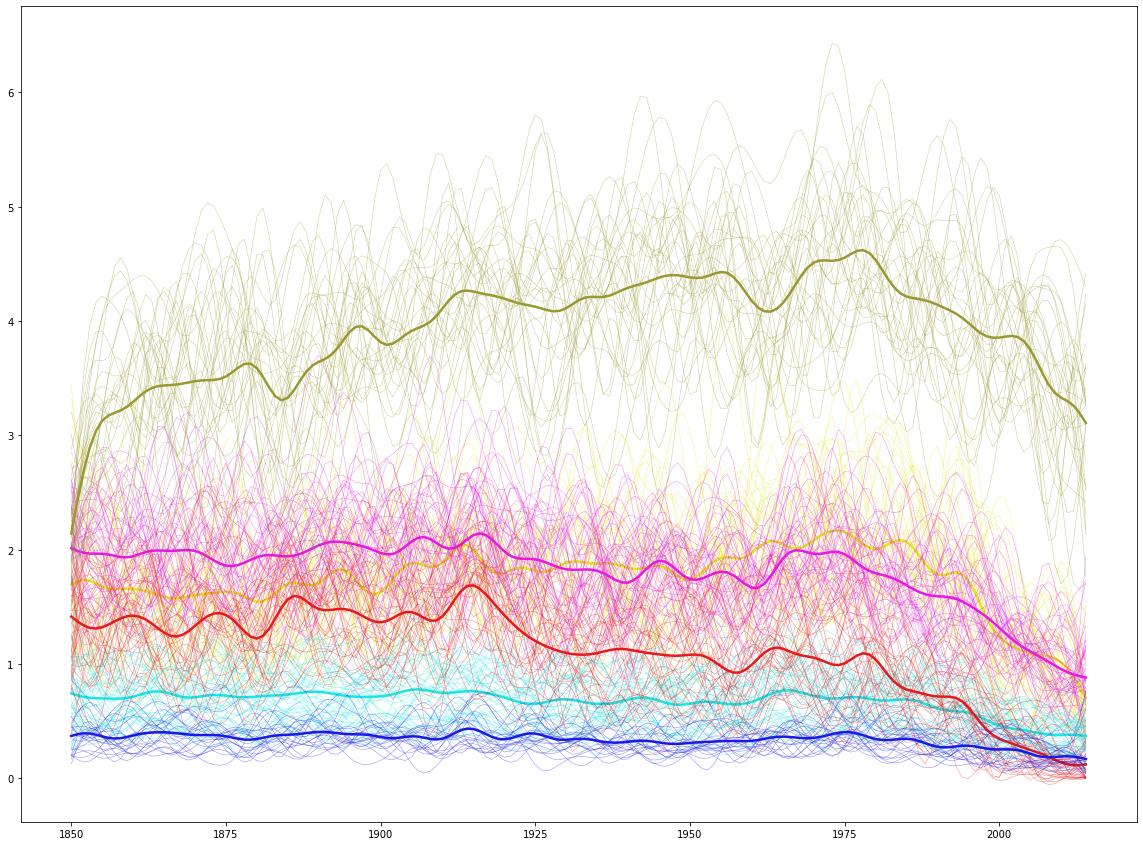

In [6]:
import matplotlib.patches as Patch

month_ = 10
region_ = 3

model_names = ['CanESM5', 'MIROC6', 'GISS-E2-1-G',
               'IPSL-CM6A-LR', 'CNRM-CM6-1', 'NorCPM1']

model_colors = [np.array([0.9,0.9,0.1]), np.array([0.9,0.1,0.9]), 
                np.array([0.1,0.9,0.9]), np.array([0.9,0.1,0.1]),
                np.array([0.1,0.1,0.9]), np.array([0.6,0.6,0.2])]

fig = plt.figure(figsize=[20,15])

for model_i, model_name in enumerate(model_names):
    
    mem_list = CMIP6_info['members'].sel(model=model_name).where(
    CMIP6_info['members'].sel(model=model_name)!='0.0', drop=True).values

    all_mem_list = []
    
    for mem_ in mem_list:
        try:
            unfiltered = xr.open_dataset(
                '/glade/work/cwpowell/low-frequency-variability/raw_data/'\
                +'regional_sea_ice_CMIP6/Regional_SIC_SIT_'\
                +f'{model_name}_{mem_}.nc')

            filt_SIC = unfiltered['regional_SIT'].sel(
                    time=unfiltered['time.month']==month_).sel(
                    region=region_).isel(member=0) * 0 + \
                filt_lowpass(unfiltered['regional_SIT'].sel(
                    time=unfiltered['time.month']==month_).sel(
                    region=region_).isel(member=0), 
                1, 0.25, 5, 0, detrend=False, standard=False)

            plt.plot(np.arange(1850,2015), filt_SIC, linewidth=0.5, alpha=0.5,
                     color=model_colors[model_i], label=model_name)

            all_mem_list.append(filt_SIC)
        
        except (FileNotFoundError):
            print(model_name, mem_)
        
    plt.plot(np.arange(1850,2015),
             xr.concat((all_mem_list),dim='member').mean('member'), 
             linewidth=2.5, color=model_colors[model_i], label=model_name)
    
# legend_elements = [Patch(facecolor=model_colors[0], label=model_names[0]),
#                    Patch(facecolor=model_colors[1], label=model_names[1]),
#                    Patch(facecolor=model_colors[2], label=model_names[2]),
#                    Patch(facecolor=model_colors[3], label=model_names[3]),
#                    Patch(facecolor=model_colors[4], label=model_names[4]),
#                    Patch(facecolor=model_colors[5], label=model_names[5]),]

# plt.legend(handles=legend_elements, 
#                           bbox_to_anchor=(-3.18, 0.1), loc='lower center', 
#                           borderaxespad=-0.25, ncol=1, fontsize=14)


2022-09-19 16:37:04.739634 FGOALS-f3-L 3
FGOALS-f3-L r1i1p1f1 0.49112709458261455 0.29174455307836233
FGOALS-f3-L r2i1p1f1 0.5067803838570589 0.27424550209747306
FGOALS-f3-L r3i1p1f1 0.4144062033241989 0.08281980132264499


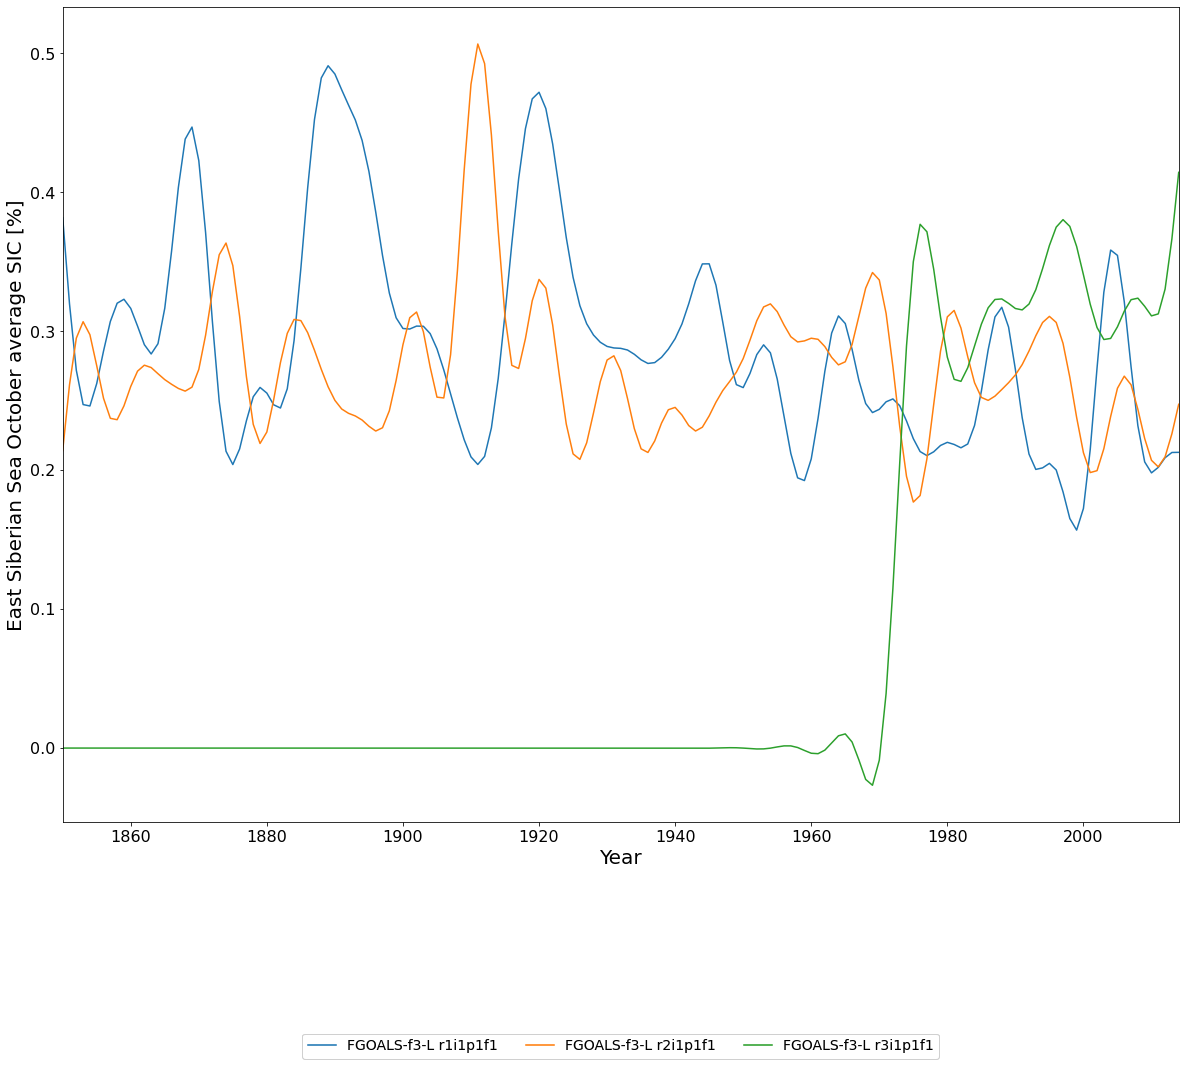

In [197]:
month_ = 11
region_ = 3

fig = plt.figure(figsize=[20,15])


count_SIC = 0

for model_name in ['FGOALS-f3-L']:#CMIP6_info['model'].values[-1:]:
    
    mem_list = CMIP6_info['members'].sel(model=model_name).where(
    CMIP6_info['members'].sel(model=model_name)!='0.0', drop=True).values
    
    print(datetime.datetime.now(), model_name, len(mem_list))

    all_mem_list = []
    
    for mem_ in mem_list:

        try:           
            unfiltered = xr.open_dataset(
                '/glade/work/cwpowell/low-frequency-variability/raw_data/'\
                +'regional_sea_ice_CMIP6/Regional_SIC_SIT_'\
                +f'{model_name}_{mem_}.nc')

            filt_SIC = unfiltered['regional_SIT'].sel(
                    time=unfiltered['time.month']==month_).sel(
                    region=region_).isel(member=0) * 0 + \
                filt_lowpass(unfiltered['regional_SIT'].sel(
                    time=unfiltered['time.month']==month_).sel(
                    region=region_).isel(member=0), 
                1, 0.25, 5, 0, detrend=False, standard=False)
                        
            all_mem_list.append(filt_SIC)  
            
            
            if np.isnan(np.max(filt_SIC)):
                print(model_name, mem_, 'CONTAINS NANS')
            else:
                count_SIC +=1
                print(model_name, mem_, np.max(filt_SIC.values), 
                      np.nanmean(filt_SIC.values))
            
        except (FileNotFoundError):
            print(model_name, mem_, 'NO DATA FOR THIS MEMBER')
        
        if len(mem_list) == 1:  
            plt.plot(np.arange(1850,2015), filt_SIC, label=model_name)

        elif mem_ == mem_list[-1] and len(all_mem_list) > 0:
            # plt.plot(np.arange(1850,2015), 
            #      xr.concat((all_mem_list),dim='member').mean('member'), 
            #      label=model_name)
            
            for mem_ in mem_list:
                plt.plot(np.arange(1850,2015), xr.concat(
                    (all_mem_list),dim='member').sel(member=mem_), 
                     label=model_name+' '+mem_)
            
    
plt.xlabel('Year', fontsize=20)
plt.ylabel('East Siberian Sea October average SIC [%]', fontsize=20)
plt.xlim(1850,2014)
# plt.ylim(-1,101)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

extra_legend = plt.legend(bbox_to_anchor=(0.5, -0.29), loc='lower center', 
                          borderaxespad=0, ncol=6, fontsize=14)

plt.gca().add_artist(extra_legend)

### Loop through each model and member, detrend, filter, then if not nan add to a single file

In [204]:
var_ = 'regional_SIT'

for model_name in CMIP6_info['model'].values[2:]:
    print(datetime.datetime.now(), model_name)
    
    try:

        mem_list = CMIP6_info['members'].sel(model=model_name).where(
        CMIP6_info['members'].sel(model=model_name)!='0.0', drop=True).values

        all_mem_filt = []
        for mem_ in mem_list:

            all_month_filtered = []
            for month_ in np.arange(1,13):

                all_region_filtered = []
                for region_ in np.arange(1,17):

                    unfiltered = xr.open_dataset(
                        '/glade/work/cwpowell/low-frequency-variability/raw_data/'\
                        +'regional_sea_ice_CMIP6/Regional_SIC_SIT_'\
                        +f'{model_name}_{mem_}.nc')

                    filt_SIC = unfiltered[var_].sel(
                            time=unfiltered['time.month']==month_).sel(
                            time=slice('1920','2014')).sel(
                            region=region_).isel(member=0) * 0 + \
                        filt_lowpass(unfiltered[var_].sel(
                            time=unfiltered['time.month']==month_).sel(
                            time=slice('1920','2014')).sel(
                            region=region_).isel(member=0), 
                        1, 0.25, 5, 0, detrend=True, standard=False)

                    filt_SIC['time'] = np.arange(1920,2015)
                    filt_SIC = filt_SIC.rename({'time':'year'})
                    all_region_filtered.append(filt_SIC)

                all_month_filtered.append(
                    xr.concat((all_region_filtered), dim='region'))

            all_month_data = xr.concat((all_month_filtered), dim='month')
            all_month_data['month'] = np.arange(1,13)

            all_mem_filt.append(all_month_data)

        all_mem_data = xr.concat((all_mem_filt), dim='member')
        all_mem_data['member'] = mem_list

        model_xr = xr.Dataset({'SIC':all_mem_data})

        model_doi = CMIP6_info['doi'].sel(model='CESM2').values

        model_xr.attrs = {
            'Description': '2 year lowpass filter of linearly detrended '\
                +'regional average sea ice thickness (SIT) in metres for the '\
                +f'climate model {model_name} for each month for 1850-2014 with '\
                +'historical forcing. Regions as defined for NSIDC MASIE-NH '\
                +'Version 1, doi:10.7265/N5GT5K3K.',
            'Timestamp'  : str(datetime.datetime.utcnow().strftime(
                "%H:%M UTC %a %Y-%m-%d")),
            'Data source': 'CMIP6 model output for sithick or siviol from'\
                 +f'{model_name}, doi:{model_doi}.',
            'Analysis'   : 'https://github.com/chrisrwp/low-fequency-variability/'\
                +'input_data/Regional_sea_ice_CMIP6.ipynb'
        }

        model_xr.to_netcdf('/glade/work/cwpowell/low-frequency-variability/'\
            +f'input_data/Regional_SIT_detrended_lowpass_{model_name}'\
            +'_1920_2014.nc')
        
    except (FileNotFoundError):
        print(model_name, 'FAILED')
    

2022-09-20 07:19:11.360633 AWI-CM-1-1-MR
AWI-CM-1-1-MR FAILED
2022-09-20 07:19:11.364014 AWI-ESM-1-1-LR
AWI-ESM-1-1-LR FAILED
2022-09-20 07:19:11.366434 BCC-CSM2-MR
2022-09-20 07:19:21.159245 BCC-ESM1
2022-09-20 07:19:30.938775 CAMS-CSM1-0
2022-09-20 07:19:40.205280 CAS-ESM2-0
2022-09-20 07:19:52.477588 CESM2
2022-09-20 07:20:26.338086 CESM2-FV2
2022-09-20 07:20:35.628448 CESM2-WACCM
2022-09-20 07:20:44.924744 CESM2-WACCM-FV2
2022-09-20 07:20:54.179191 CIESM
2022-09-20 07:21:03.400345 CMCC-CM2-SR5
2022-09-20 07:21:06.548615 CNRM-CM6-1
CNRM-CM6-1 FAILED
2022-09-20 07:22:14.376775 CNRM-CM6-1-HR
CNRM-CM6-1-HR FAILED
2022-09-20 07:22:14.379467 CNRM-ESM2-1
2022-09-20 07:22:45.142324 CanESM5
2022-09-20 07:26:05.006624 CanESM5-CanOE
2022-09-20 07:26:14.261497 E3SM-1-0
E3SM-1-0 FAILED
2022-09-20 07:26:26.635297 E3SM-1-1
2022-09-20 07:26:29.729456 E3SM-1-1-ECA
2022-09-20 07:26:32.820352 EC-Earth3
2022-09-20 07:27:34.196211 EC-Earth3-Veg
2022-09-20 07:27:52.572759 EC-Earth3-Veg-LR
2022-09-20 07:

In [184]:
test = xr.open_dataset('/glade/work/cwpowell/low-frequency-variability/'\
        +f'input_data/Regional_SIC_detrended_lowpass_ACCESS-CM2'\
        +'_1920_2014.nc')

In [200]:
test

<xarray.Dataset>
Dimensions:  (member: 3, month: 12, region: 16, year: 95)
Coordinates:
  * member   (member) object 'r1i1p1f1' 'r2i1p1f1' 'r3i1p1f1'
  * year     (year) int64 1920 1921 1922 1923 1924 ... 2010 2011 2012 2013 2014
  * region   (region) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    SIC      (member, month, region, year) float64 -0.0003211 0.0005186 ... 0.0
Attributes:
    Description:  2 year lowpass filter of linearly detrended regional averag...
    Timestamp:    22:32 UTC Mon 2022-09-19
    Data source:  CMIP6 model output for siconc (or siconca) fromACCESS-CM2, ...
    Analysis:     https://github.com/chrisrwp/low-fequency-variability/input_...

### Loop through models and save all SIC and SIT after linear detrending and filtering

In [65]:
#now combine each of the single member files together for each model
for model_name in ['GISS-E2-1-G']:#model_names:

    all_model_files = []
    for file in os.listdir('/glade/work/cwpowell/low-frequency-variability/'\
                           +'raw_data/regional_sea_ice_CMIP6/'):
        if model_name in file:
            temp_file = xr.open_dataset(
                '/glade/work/cwpowell/low-frequency-variability/raw_data/'\
                +'regional_sea_ice_CMIP6/'+file)
            all_model_files.append(temp_file)

    all_model_xr = xr.concat((all_model_files),dim='member')
    all_model_xr.to_netcdf('/glade/work/cwpowell/low-frequency-variability/'\
                           +'raw_data/regional_sea_ice_CMIP6/Regional_SIC_'\
                           +'SIT_all_mem_{}_1850_2014.nc'.format(model_name))

In [69]:
for model_name in model_names:
    
    unfiltered = xr.open_dataset(
        '/glade/work/cwpowell/low-frequency-variability/raw_data/'\
        +'regional_sea_ice_CMIP6/Regional_SIC_SIT_all_mem_'\
        +'{}_1850_2014.nc'.format(model_name)
    )

    all_month_SIC = []
    all_month_SIT = []

    for month_ in np.arange(1,13):
        #select regional average SIC data for each month, and limit to 1920-2014
        unfiltered_SIC = unfiltered['regional_SIC'].sel(
            time=unfiltered['time.month']==month_).sel(
            time=slice('1920','2014'))*100

        unfiltered_SIT = unfiltered['regional_SIT'].sel(
            time=unfiltered['time.month']==month_).sel(
            time=slice('1920','2014'))

        #filter with a 2 year lowpass filter for each month
        all_month_SIC.append(filt_lowpass(unfiltered_SIC, 1, 0.25, 5, 2, 
                                           detrend=True, standard=False)
                             )
        all_month_SIT.append(filt_lowpass(unfiltered_SIT, 1, 0.25, 5, 2, 
                                           detrend=True, standard=False)
                             )

    model_xr = xr.Dataset(
        {'SIC': xr.concat((all_month_SIC), dim='time').sortby('time'),
         'SIT': xr.concat((all_month_SIT), dim='time').sortby('time')
        }
    )
    
    model_xr.attrs = {
        'Description': '2 year lowpass filter of linearly detrended '\
            +'regional average sea ice concentration (SIC) in % and sea ice '\
            +'thickness (SIT) in meters for the climate model '\
            +'{} for each month for 1850-2014 with '.format(model_name)\
            +'historical forcing. Regions as defined for NSIDC MASIE-NH '\
            +'Version 1, doi:10.7265/N5GT5K3K.',
        'Timestamp'  : str(datetime.datetime.utcnow().strftime(
            "%H:%M UTC %a %Y-%m-%d")),
        'Data source': 'CMIP6 model output for siconc and sithick from'\
             +'{}, doi:{}.'.format(model_name, doi_dict[model_name]),
        'Analysis'   : 'https://github.com/chrisrwp/low-fequency-variability/'\
            +'input_data/Regional_sea_ice_CMIP6.ipynb'
    }

    model_xr.to_netcdf('/glade/work/cwpowell/low-frequency-variability/'\
        +'input_data/Regional_SIC_SIT_detrended_lowpass_'\
        +'{}_1920_2014.nc'.format(model_name)
                      )